In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 28.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='NCI1')
# dataset = TUDataset(root='data/TUDataset', name='ENZYMES')
# dataset = TUDataset(root='data/TUDataset', name='QM9')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: NCI1(4110):
Number of graphs: 4110
Number of features: 37
Number of classes: 2

Data(edge_index=[2, 42], x=[21, 37], y=[1])
Number of nodes: 21
Number of edges: 42
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [3]:
import networkx as nx
import torch_geometric

max_degrees = []

for data in dataset:
    graph = torch_geometric.utils.to_networkx(data, to_undirected=True)
    degrees = list(graph.degree())
    #print(degrees)
    max_degree_node, max_degree = max(degrees, key=lambda x: x[1])
    max_degrees.append(max_degree)

print(max(max_degrees))

4


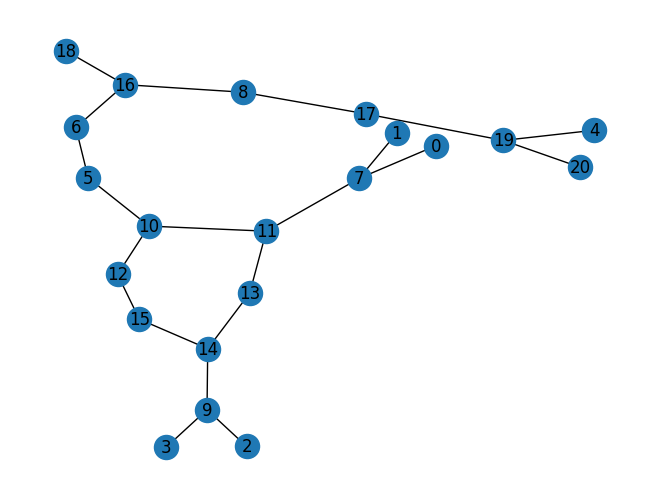

[{10, 11, 12, 13, 14, 15}, {0, 7}, {1, 7}, {9, 2}, {9, 3}, {19, 4}, {16, 10, 5, 6}, {8, 17, 19, 16}, {16, 18}, {19, 20}]


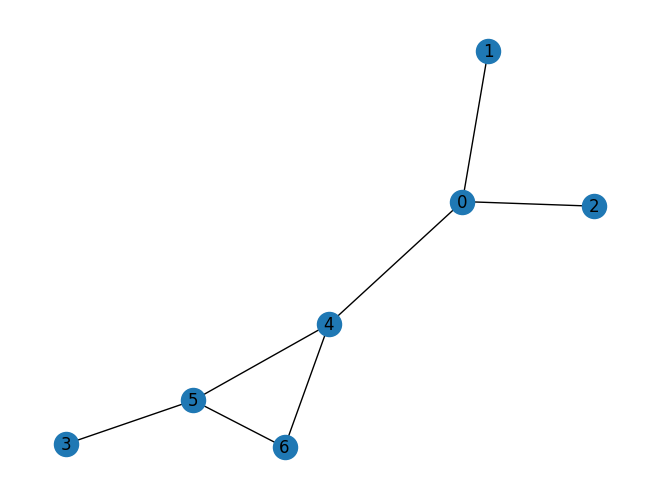

{0: {10, 11, 12, 13, 14, 15}, 1: {0, 1, 11, 7}, 2: {9, 2, 3, 14}, 3: {17, 19, 4, 20}, 4: {16, 10, 5, 6}, 5: {8, 17, 19, 16}, 6: {16, 18}}


In [8]:
import networkx as nx
import torch_geometric
from collections import deque
import collections
import matplotlib.pyplot as plt

#edge_index = torch.tensor([[0, 1, 1, 2],
#                           [1, 0, 2, 1]], dtype=torch.long)
#x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
edge_index = dataset[0].edge_index
x = dataset[0].x
# 8 nodes with crossover:
#edge_index = torch.tensor([[0, 1, 0, 2, 1, 3, 2, 4, 2, 5, 3, 4, 3, 5, 4, 6, 5, 7, 6, 7],
#                           [1, 0, 2, 0, 3, 1, 4, 2, 5, 2, 4, 3, 5, 3, 6, 4, 7, 5, 7, 6]], dtype=torch.long)
# 8 nodes without crossover:
#edge_index = torch.tensor([[0, 1, 0, 2, 1, 3, 2, 3, 2, 4, 6, 4, 3, 5, 4, 5, 5, 7, 6, 7],
#                           [1, 0, 2, 0, 3, 1, 3, 2, 4, 2, 4, 6, 5, 3, 5, 4, 7, 5, 7, 6]], dtype=torch.long)
#x = torch.tensor([[0] for _ in edge_index[0]], dtype=torch.float)

data = torch_geometric.data.Data(x=x, edge_index=edge_index)
test_graph = torch_geometric.utils.to_networkx(data, to_undirected=True)


'''Assumes that the degree of start_node is less than or equal to 2.'''
def create_branch(graph, start_node):
    new_branch = set()
    nodes_stack = deque()
    nodes_stack.append(start_node)
    while len(nodes_stack) > 0:
        current_node = nodes_stack.pop()
        new_branch.add(current_node)
        if graph.degree(current_node) <= 2:
            for neigh in graph.neighbors(current_node):
                if (not neigh in new_branch) and (not neigh in nodes_stack):
                    nodes_stack.append(neigh)
    return new_branch

def compute_components(graph):
    components = []
    #print("comp comps")
    #k_components_dict = nx.k_components(graph)
    k_components = nx.biconnected_components(graph)
    #print(k_components)
    #print("comp'ed comps")
    node_to_components = {node: {"k": [], "branch": []} for node in list(graph.nodes)}
    left_over_nodes = set(graph.copy().nodes)
    #print(left_over_nodes)
    #print(k_components_dict)

    graph_creator = ComponentGraphCreator(graph)
    #for k, k_components in k_components_dict.items():
        #if k < 3 and 1 < k:
    for k_component in k_components:
        if len(k_component) < 3:
            continue
        components.append(k_component)
        graph_creator.add_component(k_component)
        for node in k_component:
            node_to_components[node]["k"].append(k_component)
            #print("2-comp nodes: " + str(node))
        left_over_nodes = left_over_nodes - k_component

    #print(left_over_nodes)
    for node in left_over_nodes:
        #print("left over nodes: " + str(node))
        if graph.degree(node) <= 2:
            if len(node_to_components[node]["branch"]) == 0:
                #print(node)
                branch = create_branch(graph, node)
                components.append(branch)
                graph_creator.add_component(branch)
                #print(branch)
                for branch_node in branch:
                    node_to_components[branch_node]["branch"].append(branch)

    graph_creator.add_edges()

    return components, node_to_components, graph_creator

nx.draw(test_graph, with_labels=True)
plt.show()
#print(nx.k_components(test_graph))
#for cmp in components:
#    g = test_graph.subgraph(cmp)
#    nx.draw(g, with_labels=True)
#    plt.show()

components, node_to_components, graph_creator = compute_components(test_graph)
component_graph = graph_creator.graph
nx.draw(component_graph, with_labels=True)
cmp_graph, cmp_node_to_cgc_nodes, cmp_cgc_node_to_component = graph_creator.get_graph_and_dicts()
print(components)
plt.show(cmp_graph)
print(cmp_cgc_node_to_component)
#print(cut_nodes)
#cycles = list(nx.simple_cycles(graph))
#print("Cycles:", cycles)



In [9]:
from collections import Counter

ds = []
for data in dataset:
    edge_index = data.edge_index
    x = data.x
    data = torch_geometric.data.Data(x=x, edge_index=edge_index)
    test_graph = torch_geometric.utils.to_networkx(data, to_undirected=True)
    components, node_to_components, graph_creator = compute_components(test_graph)
    component_graph = graph_creator.graph
    if nx.is_connected(component_graph):
        ds.append(nx.diameter(component_graph))
print(max(ds))
print(len(ds))
print(sum(ds)/len(ds))
print(ds)
print(Counter(ds))

14
1393
3.137832017229002
[4, 4, 4, 4, 5, 3, 2, 3, 3, 2, 2, 2, 4, 3, 4, 4, 5, 2, 3, 3, 5, 3, 4, 2, 4, 4, 3, 3, 2, 5, 2, 4, 3, 2, 4, 4, 4, 3, 2, 5, 2, 2, 3, 6, 3, 3, 4, 4, 2, 3, 4, 2, 3, 3, 2, 2, 3, 3, 3, 5, 2, 1, 4, 2, 4, 2, 2, 3, 2, 0, 5, 0, 4, 2, 4, 5, 2, 4, 1, 5, 5, 4, 2, 3, 2, 5, 4, 1, 2, 5, 3, 2, 2, 2, 4, 3, 4, 3, 3, 4, 1, 2, 5, 6, 4, 4, 4, 4, 3, 4, 4, 2, 3, 4, 5, 2, 4, 3, 0, 5, 2, 4, 2, 2, 2, 3, 2, 2, 2, 2, 3, 5, 2, 6, 3, 2, 2, 2, 2, 3, 2, 4, 3, 3, 2, 2, 2, 4, 2, 4, 2, 2, 5, 3, 2, 2, 5, 3, 4, 3, 6, 2, 2, 4, 4, 4, 3, 3, 4, 4, 2, 3, 4, 4, 7, 3, 4, 3, 3, 2, 2, 4, 4, 2, 2, 4, 2, 2, 2, 2, 1, 3, 3, 3, 3, 4, 2, 3, 4, 3, 3, 3, 5, 4, 4, 2, 4, 3, 4, 4, 5, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 0, 2, 4, 4, 4, 2, 2, 2, 1, 2, 6, 6, 4, 2, 3, 2, 5, 4, 4, 4, 4, 2, 2, 4, 5, 2, 2, 4, 2, 5, 3, 3, 3, 2, 4, 2, 4, 2, 3, 2, 0, 2, 3, 2, 2, 6, 2, 4, 2, 2, 2, 2, 4, 2, 3, 2, 3, 4, 1, 3, 5, 3, 2, 2, 2, 2, 2, 4, 6, 4, 3, 2, 2, 5, 2, 2, 1, 3, 2, 2, 3, 2, 2, 3, 2, 6, 4, 3, 4, 4, 2, 5, 3, 2, 4, 5, 2, 2, 4, 2, 4, 8, 3, 2

In [7]:
class ComponentGraphCreator():
    def __init__(self, org_graph):
        self.org_graph = org_graph
        self.graph = nx.Graph()
        self.current_node_index = 0
        self.node_to_cgc_nodes = {}
        self.cgc_node_to_component = {}
        self.potential_forks = []

    '''Assumes that len(component) <= 2.'''
    def add_fork_component(self, component):
        cgc_node = None
        for node in component:
            if node in self.node_to_cgc_nodes and "fork node" in self.node_to_cgc_nodes[node]:
                cgc_node = self.node_to_cgc_nodes[node]["fork node"]
                break
        else:
            cgc_node = self.current_node_index
            self.potential_forks.append(cgc_node)
            self.cgc_node_to_component[cgc_node] = set()
            self.graph.add_node(cgc_node)
            self.current_node_index += 1
        for node in component:
            if not node in self.node_to_cgc_nodes:
                self.node_to_cgc_nodes[node] = {}
                self.node_to_cgc_nodes[node]["component nodes"] = []
            self.node_to_cgc_nodes[node]["fork node"] = cgc_node
            self.node_to_cgc_nodes[node]["component nodes"].append(cgc_node)
            self.cgc_node_to_component[cgc_node].add(node)

    def add_component(self, component):
        # a component with length <= 2 is necessarily a branch.
        # below, we make sure that all compinents of lenght <= 2
        # that share cut points are combined, into what we call a fork.
        if len(component) <= 2:
            self.add_fork_component(component)
            return

        self.graph.add_node(self.current_node_index)
        self.cgc_node_to_component[self.current_node_index] = component
        for node in component:
            if node in self.node_to_cgc_nodes:
                self.node_to_cgc_nodes[node]["component nodes"].append(self.current_node_index)
            else:
                self.node_to_cgc_nodes[node] = {}
                self.node_to_cgc_nodes[node]["component nodes"] = [self.current_node_index]
        self.current_node_index += 1

    def complete_forks(self):
        for potential_fork in self.potential_forks:
            component = self.cgc_node_to_component[potential_fork]
            size = len(component)
            special_node = None
            for node in component:
                if (special_node == None) and (self.org_graph.degree(node) == size):
                    special_node = node
                elif self.org_graph.degree(node) != 1:
                    special_node = None
                    break
            if special_node != None:
                neigh = list(set(self.org_graph.neighbors(special_node)) - component)[0]
                self.cgc_node_to_component[potential_fork].add(neigh)
                if neigh not in self.node_to_cgc_nodes:
                    self.node_to_cgc_nodes[neigh] = {}
                    self.node_to_cgc_nodes[neigh]["component nodes"] = []
                self.node_to_cgc_nodes[neigh]["component nodes"].append(potential_fork)


    def add_edges(self):
        self.complete_forks()

        components = self.cgc_node_to_component.values()
        counter = collections.Counter(node for component in components for node in component)
        cut_nodes = [node for (node, count) in counter.most_common() if count > 1]

        for cut_node in cut_nodes:
            cgc_nodes = self.node_to_cgc_nodes[cut_node]["component nodes"]
            if len(cgc_nodes) < 2:
                continue
            cgc_node_pairs = [(n1, n2) for n1 in cgc_nodes for n2 in cgc_nodes if n1 != n2]
            #print(cgc_node_pairs)
            self.graph.add_edges_from(cgc_node_pairs)

    def get_graph_and_dicts(self):
        return self.graph, self.node_to_cgc_nodes, self.cgc_node_to_component

In [10]:
#torch.manual_seed(12345)
dataset = dataset.shuffle()

num_data = len(dataset)
num_train_data = int(0.9 * num_data)
train_dataset = dataset[:num_train_data]
test_dataset = dataset[num_train_data:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 3699
Number of test graphs: 411


In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

In [ ]:
from torch_geometric.utils.convert import from_networkx
train_batches = []

for batch_data in train_loader:
    subgraphs = extract_subgraphs(batch_data)
    components_graphs = []
    for G in subgraphs:
        components, node_to_components, graph_creator = compute_components(G)
        cmp_graph, node_to_cmp_nodes, cmp_node_to_component = graph_creator.get_graph_and_dicts()
        components_graphs.append({"components_graph": from_networkx(cmp_graph).edge_index, "cmp_node_to_component": cmp_node_to_component})
    batch_data.components_graphs = components_graphs
    train_batches.append(batch_data)

In [ ]:
print(train_batches[0].components_graphs)

In [13]:
#sample_batch = next(iter(train_loader))
def extract_subgraphs(batch_data, batch_graph):
    num_graphs = len(batch_data.y)
    subgraph_nodes = [set() for g in range(num_graphs)]
    node_to_graph = batch_data.batch
    for node in range(len(node_to_graph)):
        subgraph_nodes[node_to_graph[node]].add(node)
    subgraphs = [batch_graph.subgraph(c).copy() for c in subgraph_nodes]
    return subgraphs

#print(sample_batch)
#subgraphs = extract_subgraphs(sample_batch)
#print(len(subgraphs))
#nx.draw(subgraphs[7], with_labels=True)

In [14]:
from torch_geometric.utils.convert import from_networkx

def augment_loader(loader):
    component_graphs = []#{}
    list_loader = []
    for batch_data in loader:
        list_loader.append(batch_data)
        batch_graph = torch_geometric.utils.to_networkx(batch_data, to_undirected=True)
        subgraphs = extract_subgraphs(batch_data, batch_graph)
        batch_component_graphs = []
        for G in subgraphs:
            components, node_to_components, graph_creator = compute_components(G)
            cmp_graph, node_to_cmp_nodes, cmp_node_to_component = graph_creator.get_graph_and_dicts()
            batch_component_graphs.append({"components_graph": from_networkx(cmp_graph), "node_to_cmp_nodes": cmp_node_to_component})
        #hash = nx.weisfeiler_lehman_graph_hash(batch_graph)
        #component_graphs[hash] = batch_component_graphs
        component_graphs.append(batch_component_graphs)
    #loader.component_graphs = component_graphs
    return {"loader": list_loader, "component_graphs": component_graphs}

In [ ]:
augment_loader(test_loader)
component_graph = test_loader.component_graphs[0][-1]
test_loader.component_graphs[0]
print(component_graph)

In [ ]:
for i, G in enumerate(subgraphs):
    print("doing graph " + str(i))
    components, node_to_components, graph_creator = compute_components(G)
    #component_graph = graph_creator.graph
    #nx.draw(component_graph, with_labels=True)
    #cmp_graph, cmp_node_to_cgc_nodes, cmp_cgc_node_to_component = graph_creator.get_graph_and_dicts()
    #print(components)
    #plt.show(cmp_graph)
    #print(cmp_cgc_node_to_component)

In [15]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool


class BasicGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        #super(GCN, self).__init__()
        super().__init__()
        torch.manual_seed(12345)
        #self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.lin1 = Linear(hidden_channels, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.lin4 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch, component_graphs):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = self.lin2(x)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = self.lin3(x)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = self.lin4(x)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)

        return x

#model = GCN(hidden_channels=64)
#print(model)

In [16]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
import numpy as np


class ExtendedGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        #super(GCN, self).__init__()
        #torch.manual_seed(12345)
        super().__init__()
        #self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.lin1 = Linear(hidden_channels, hidden_channels)
        #self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)

        self.component_conv1 = GraphConv(hidden_channels, hidden_channels)
        self.component_lin1 = Linear(hidden_channels, hidden_channels)
        self.component_conv2 = GraphConv(hidden_channels, hidden_channels)
        self.component_lin2 = Linear(hidden_channels, dataset.num_classes)

        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GraphConv(dataset.num_node_features, hidden_channels)
        #self.lin3 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch, component_graphs):
        # 1. Obtain node embeddings
        #print(x.shape)
        x = self.conv1(x, edge_index)
        x = self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = self.lin2(x)
        x = x.relu()
        #print(x.shape)

        #feature_lists = [[] for _ in len(component_graphs)]
        #for node, feature in enumerate(x):
        #    feature_lists[batch[node]].append(feature)
        final_x = torch.zeros(len(component_graphs), dataset.num_classes)
        #print(component_graphs)
        for i, component_graph in enumerate(component_graphs):
            cmp_node_to_component = component_graph["node_to_cmp_nodes"]
            cmp_graph = component_graph["components_graph"]
            #component_features = np.zeros((len(cmp_node_to_component), 40))
            component_features = torch.zeros(len(cmp_node_to_component), 40)
            #print(len(cmp_node_to_component))
            #print(cmp_node_to_component)
            #print(cmp_graph)
            for key, value in cmp_node_to_component.items():
                for node in value:
                    component_features[key] += x[node]
            #component_features = [0 for _ in range(len(cmp_node_to_component))]
            #for key, value in cmp_node_to_component.items():
            #    summands = []
            #    for node in value:
            #        summands.append(x[node])
            #    component_features[key] = sum(summands)
            #print(component_features)
            #component_features = np.array(component_features)
            #print(cmp_graph.edge_index)
            #print(component_features)
            self.component_conv1(component_features, cmp_graph.edge_index)
            component_features = self.component_lin1(component_features)
            component_features = self.component_conv2(component_features, cmp_graph.edge_index)
            component_features = self.component_lin2(component_features)
            component_features = sum(component_features)/len(component_features)#global_mean_pool(component_features, torch.zeros(len(component_features)))
            final_x[i] += component_features
        x = final_x

        # 2. Readout layer
        #x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)

        return x

#model = GCN(hidden_channels=64)
#print(model)

In [17]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_acc = 0

    def early_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc:
            self.max_validation_acc = validation_acc
            self.counter = 0
        elif validation_acc < (self.max_validation_acc - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [18]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

batch_data_ex = None

def train(model, train_loader, optimizer, criterion):
    loader = train_loader["loader"]
    model.train()

    component_graphs = train_loader["component_graphs"]
    for i, data in enumerate(loader):  # Iterate in batches over the training dataset.
         #batch_graph = torch_geometric.utils.to_networkx(data, to_undirected=True)
         #hash = nx.weisfeiler_lehman_graph_hash(batch_graph)
         out = model(data.x, data.edge_index, data.batch, component_graphs[i])#, None)  # Perform a single forward pass.
         #batch_data_ex = data
         #raise Exception()
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(model, test_loader):
     loader = test_loader["loader"]
     model.eval()

     correct = 0
     component_graphs = test_loader["component_graphs"]
     for i, data in enumerate(loader):  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch, component_graphs[i])#, None)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     #return correct / len(loader.dataset)  # Derive ratio of correct predictions.
     return correct / len(loader)  # Derive ratio of correct predictions.

def train_model(model, train_loader, test_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    early_stopper = EarlyStopper(patience=3, min_delta=0.03)
    for epoch in range(1, 171):
        train(model, train_loader, optimizer, criterion)
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        if early_stopper.early_stop(test_acc):
            print("Best Test Acc: " + str(early_stopper.max_validation_acc))
            break

<IPython.core.display.Javascript object>

In [ ]:
from torch_geometric.loader import DataLoader

def assess_model(model, dataset):
    torch.manual_seed(12345)
    dataset = dataset.shuffle()

    num_data = len(dataset)
    test_train_proportion = 0.1
    num_test_data = int(test_train_proportion * num_data)
    num_splits = int(1/test_train_proportion)

    for i in range(num_splits):
        train_dataset = dataset[((i + 1) * num_test_data):]
        if i > 0:
            train_dataset += dataset[((i - 1) * num_test_data) : (i * num_test_data)]
        test_dataset = dataset[(i * num_test_data) : ((i + 1) * num_test_data)]

        print(f'Number of training graphs: {len(train_dataset)}')
        print(f'Number of test graphs: {len(test_dataset)}')

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        train_loader = augment_loader(train_loader)
        #print(train_loader.component_graphs)
        test_loader = augment_loader(test_loader)
        #print(test_loader.component_graphs)

        print("Testing on " + str(i + 1) + "th dataset split.")
        train_model(model, train_loader, test_loader)


#model = BasicGNN(hidden_channels=40)
model = ExtendedGNN(hidden_channels=40)
assess_model(model, dataset)